# Topic Modeling of Tweets

In [1]:
import pandas as pd
import numpy as np
import pre_processing as pp
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim

/Users/LokiJo/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/LokiJo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/LokiJo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 1. Pre-processing: Cleaning and tokenization of tweets

In [7]:
tweets = pd.read_csv('data/tweets_w_scores.csv')
tweets = tweets[tweets.text.notnull()]
print(tweets.shape)
tweets.head()

(20697, 9)


,id,topic,source,text,replyCount,vaderMean,vaderStd,vaderCatLabel,vaderCat
0,1377385383168765952,NaN,FoxNews,activists protest renaming chicago school afte...,306,-0.052830,0.445459,medium,1.0
1,1377384607969013765,NaN,FoxNews,border patrol video shows smugglers abandoning...,108,-0.045958,0.495337,medium,1.0
2,1377384339105669122,NaN,FoxNews,cause of tiger woods car crash determined but ...,169,-0.034919,0.424833,medium,1.0
3,1377367836046192641,NaN,FoxNews,gop rep urges hhs to halt reported plan to rel...,80,0.043459,0.495874,medium,1.0
4,1377358399759785987,NaN,FoxNews,some democrats trying to stop iowa new hampshi...,96,-0.040135,0.433053,medium,1.0


In [9]:
# remove words that start with @
tweets['text'] = tweets['text'].str.replace('(\@\w+.*?)',"")
# remove words that start with https
tweets['text'] = tweets['text'].str.replace(r"http\S+","")
# other cleaning stuff
tweets['cleaned_text'] = tweets['text'].apply(pp.clean_text, stopwords=True,
                                              add_sw = ['u', 'said', 'says', 'icymi',
                                                       'th', 'n', 'seen', 'watch', 'may', 'year',
                                                       'would', 'say', 'de', 'get', 'could']
                                             )

tweets.cleaned_text[348]

<ipython-input-9-7c890815308e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['text'] = tweets['text'].str.replace('(\@\w+.*?)',"")
<ipython-input-9-7c890815308e>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['text'] = tweets['text'].str.replace(r"http\S+","")


'cuomo accuser lindsey boylan claims governor joked try mount dog'

### 1.1 Get the bi-grams and tokenize each article

In [10]:
pre_process_docs = pp.bi_gram(tweets.cleaned_text, min_count=15, threshold=50)
pre_process_docs = [pp.remove_stopwords(d, add_sw=['new', 'two', 'one', 'three']) for d in pre_process_docs]

In [11]:
pre_process_docs[348]

'cuomo accuser lindsey boylan claims governor joked try mount dog'

### 1.13 Tokenize

In [12]:
docs = [word_tokenize(doc) for doc in pre_process_docs] #Tokenize
print(docs[500])

['chicago', 'car', 'theft', 'happens', 'next', 'barstool', 'sports', 'founder', 'dave', 'portnoy', 'caught', 'video']


## 2. Topic Modeling with LDA

In [13]:
# Create a dictionary representation of the documents. 
dictionary = gensim.corpora.Dictionary(docs) 
print('Number of unique tokens: %d' % len(dictionary))

# Filter out words that occur more than 50% of the documents.
dictionary.filter_extremes(no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

#print('Number of unique tokens after filtering: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 21768
Number of documents: 20697


In [14]:
 #LdaMulticore uses all CPU cores to parallelize and speed up model training.
lda_model = gensim.models.LdaMulticore(corpus, num_topics = 15,
                                       id2word = dictionary, passes = 15,
                                       workers = 3, random_state=0)

In [15]:
topics = ['Border Crisis', 'International', 'Politics', 'Pandemic', 'Politics',
         'COVID', 'Finance', 'Economy', 'Other', 'BLM',
         'COVID', 'Other', 'Women Violence', 'UK', 'Business']
for idx, topic in lda_model.print_topics(-1):
    print('Topic {}: {} \nWords: {}'.format(idx+1, topics[idx],topic))
    print('')

Topic 1: Border Crisis 
Words: 0.033*"police" + 0.020*"killed" + 0.012*"shooting" + 0.010*"shot" + 0.009*"people" + 0.009*"attack" + 0.009*"suez_canal" + 0.008*"capitol" + 0.007*"dead" + 0.007*"old"

Topic 2: International 
Words: 0.050*"vaccine" + 0.036*"covid" + 0.015*"astrazeneca" + 0.014*"eu" + 0.012*"million" + 0.011*"vaccines" + 0.009*"health" + 0.007*"doses" + 0.007*"exclusive" + 0.006*"coronavirus"

Topic 3: Politics 
Words: 0.011*"workers" + 0.010*"union" + 0.009*"women" + 0.008*"day" + 0.007*"time" + 0.007*"years" + 0.007*"amazon" + 0.006*"first" + 0.006*"election" + 0.005*"home"

Topic 4: Pandemic 
Words: 0.015*"myanmar" + 0.012*"bill" + 0.011*"senate" + 0.008*"black" + 0.008*"protesters" + 0.008*"georgia" + 0.008*"law" + 0.008*"republican" + 0.007*"hong_kong" + 0.006*"state"

Topic 5: Politics 
Words: 0.020*"ukraine" + 0.009*"uk" + 0.008*"companies" + 0.007*"global" + 0.007*"covid" + 0.006*"police" + 0.006*"mcconnell" + 0.006*"treasury_secretary" + 0.005*"janet_yellen" + 0.

### 2.2 LDA Model Results: Topics Visualization

In [16]:
#For each documents, get the one topic which dominates the most

def dominant_per_document(ldamodel, corpus, texts):
    '''
    Get top topic per document
    '''
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                
                wp = ldamodel.show_topic(topic_num)
                
                topic_keywords = ", ".join([word for word, prop in wp])
                
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4),
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    
    sent_topics_df.columns = ['Dominant_Topic',
                              'Perc_Contribution',
                              'Topic_Keywords']
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    
    sent_topics_df['text'] = contents
    
    return sent_topics_df

In [17]:
dominant_topics = dominant_per_document(ldamodel=lda_model,
                                        corpus=corpus,
                                        texts=pre_process_docs)
dominant_topics['topic_name'] = dominant_topics['Dominant_Topic'].apply(lambda x: topics[int(x)])
dominant_topics

,Dominant_Topic,Perc_Contribution,Topic_Keywords,text,topic_name
0,3.0,0.5366,"myanmar, bill, senate, black, protesters, geor...",activists protest renaming chicago school oppr...,Pandemic
1,10.0,0.8963,"people, border, vaccinated, pandemic, city, ch...",border_patrol video shows smugglers abandoning...,COVID
2,8.0,0.5714,"russia, russian, putin, prince_philip, militar...",cause tiger_woods car crash determined truth n...,Other
3,1.0,0.2956,"vaccine, covid, astrazeneca, eu, million, vacc...",gop rep urges hhs halt reported plan release c...,International
4,3.0,0.7020,"myanmar, bill, senate, black, protesters, geor...",democrats trying stop iowa hampshire voting first,Pandemic
...,...,...,...,...,...
20692,4.0,0.6445,"ukraine, uk, companies, global, covid, police,...",special envoy tells security_council act avoid...,Politics
20693,14.0,0.8963,"george_floyd, trial, derek_chauvin, police_off...",wisconsin high court voids governors mask_mand...,Business
20694,5.0,0.5141,"new_york, first, use, cuomo, vaccine, johnson_...",analysis biden infrastructure_plan bets big re...,COVID
20695,6.0,0.4784,"biden, president, bidens, plan, first, white_h...",analysis deliveroos flop wake call tech hopefuls,Finance


In [18]:
topic_weights = [dict(lda_model[x]) for x in corpus]
topic_weights = pd.DataFrame(topic_weights)
print("Topic Weights per Document")
topic_weights

Topic Weights per Document


,3,6,10,8,11,1,7,12,2,0,14,4,5,9,13
0,0.536620,0.339540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.896283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.571196,0.332470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.167271,0.113810,0.247910,NaN,NaN,0.295659,0.081662,0.050800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.647840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.228335,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20692,0.259108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.644578,NaN,NaN,NaN
20693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.896254,NaN,NaN,NaN,NaN
20694,NaN,0.246368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.514013,NaN,0.159604
20695,0.013336,0.478430,0.013336,0.013336,0.013336,0.013336,0.348204,0.013336,0.013336,0.013336,0.013336,0.013336,0.013336,0.013336,0.013336


In [19]:
#Obtain the mean weight contribution of each topic and the count
stats = []
for col in topic_weights:
    d = {}
    d['mean_weight'] = topic_weights[col].mean()
    d['count'] = topic_weights[col].count()
    d['topic'] = col
    stats.append(d)

stats = pd.DataFrame(stats)
#Aggregate and merge all results
topic_counts = dominant_topics.groupby('Dominant_Topic').size().reset_index(name='dominant_count')

topic_counts = topic_counts.sort_values(by='dominant_count', ascending=False)
topic_counts = topic_counts.merge(stats, left_on='Dominant_Topic',
                                  right_on='topic').drop(columns='Dominant_Topic')

topic_counts.sort_values(by='topic', inplace=True)
topic_counts.reset_index(drop=True, inplace=True)

topic_counts['topic_name'] = topic_counts.apply(lambda x: topics[int(x['topic'])],
                                                axis=1)

wm = lambda x: np.average(x, weights=topic_counts.loc[x.index, "dominant_count"])

tc = topic_counts.groupby('topic_name').agg(mean_weight = ('mean_weight', wm)).reset_index()
tc2 = topic_counts.groupby('topic_name').agg(dominant_count = ('dominant_count', 'sum')).reset_index()

topic_counts = tc.merge(tc2)
topic_counts

,topic_name,mean_weight,dominant_count
0,BLM,0.220576,1231
1,Border Crisis,0.212768,1208
2,Business,0.224051,1415
3,COVID,0.235214,3249
4,Economy,0.185255,903
5,Finance,0.244225,1738
6,International,0.268238,2016
7,Other,0.243119,3069
8,Pandemic,0.241828,1702
9,Politics,0.204285,2126


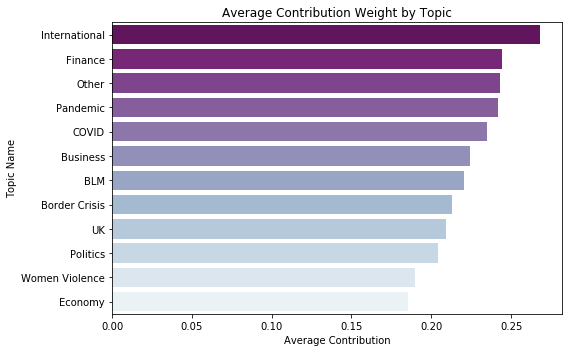

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
#topic_counts.sort_values(by='count', ascending=False, inplace=True)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))

sns.barplot(y="topic_name", x="mean_weight", 
            data=topic_counts.sort_values(by='mean_weight', 
                                          ascending=False),
            ax=ax1, palette='BuPu_r')
ax1.set_title('Average Contribution Weight by Topic', 
              fontdict=dict(size=12))
ax1.set_xlabel('Average Contribution')
ax1.set_ylabel('Topic Name')
fig.tight_layout();

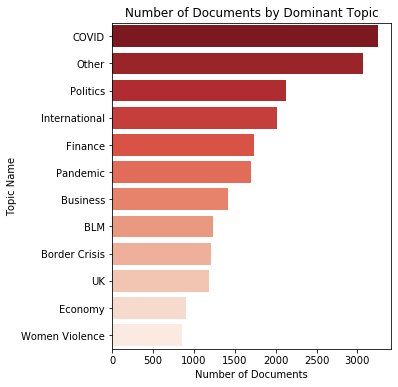

In [21]:
fig, ax1 = plt.subplots(figsize=(5, 6))
sns.barplot(y="topic_name", x="dominant_count",
data=topic_counts.sort_values(by='dominant_count',
                              ascending=False), 
            ax=ax1, palette='Reds_r')
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=12))
ax1.set_xlabel('Number of Documents')
ax1.set_ylabel('Topic Name');

In [29]:
tweets['topic'] = dominant_topics['Dominant_Topic'].apply(lambda x: topics[int(x)])
tweets.drop(['cleaned_text'], axis=1).to_csv('data/tweets_all.csv', index=False)

In [30]:
tweets[['text', 'topic']]

,text,topic
0,activists protest renaming chicago school afte...,Pandemic
1,border patrol video shows smugglers abandoning...,COVID
2,cause of tiger woods car crash determined but ...,Other
3,gop rep urges hhs to halt reported plan to rel...,International
4,some democrats trying to stop iowa new hampshi...,Pandemic
...,...,...
20693,u n special envoy tells security council to a...,Business
20694,wisconsin high court voids governors mask mand...,COVID
20695,analysis biden infrastructure plan bets big o...,Finance
20696,analysis deliveroos flop a wake up call for t...,Business


In [31]:
tweets[['text', 'topic']].iloc[17928].text

'nato demands russia end ukraine build up west examines options'